## Median Filter

Le filtre médian est un filtre numérique ,  utilisé pour la réduction de bruit.  tout en conservant les contours de l'image.

### Principe

L'idée principale du filtre médian est de remplacer chaque entrée par la valeur médiane de son voisinage.

Par exemple, si on considère ces neufs pixels, dont une valeur aberrante (ici 200) :
![Expliaction median filtre](assets/median.jpg "Ecplication")




le filtre médian va considérer les valeurs du voisinage par valeurs croissantes :
5 47 71 80 94 105 121 150 200

et prendre la valeur médiane, ici la valeur 94. La sortie du filtre donnera donc :

| 5 |	47  |	71 |
|-----------------|
| 80 |	**94** | 	105|
| 121 |	150   | 	200 |

ce qui a permis de remplacer la valeur aberrante par une valeur « de consensus » entre les valeurs voisines.



https://fr.wikipedia.org/wiki/Filtre_m%C3%A9dian



## 1 en parallele

In [13]:
import pyopencl as cl
import numpy as np
from scipy.misc import imread, imsave
from time import time
#Read in image
img = imread('assets/originale.png', flatten=True).astype(np.float32)

# Get platforms, both CPU and GPU
plat = cl.get_platforms()
CPU = plat[0].get_devices()
try:
    GPU = plat[1].get_devices()
except IndexError:
    GPU = "none"

#Create context for GPU/CPU
if GPU!= "none":
    ctx = cl.Context(GPU)
else:
    ctx = cl.Context(CPU)

print("GPU : "+str(GPU))
print("CPU : "+str(CPU))


GPU : none
CPU : [<pyopencl.Device 'pthread-Intel(R) Xeon(R) CPU E3-1240 v5 @ 3.50GHz' on 'Portable Computing Language' at 0x94354e0>]


In [14]:

# Create queue for each kernel execution
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags

# Kernel function
src = '''
void sort(int *a, int *b, int *c) {
   int swap;
   if(*a > *b) {
      swap = *a;
      *a = *b;
      *b = swap;
   }
   if(*a > *c) {
      swap = *a;
      *a = *c;
      *c = swap;
   }
   if(*b > *c) {
      swap = *b;
      *b = *c;
      *c = swap;
   }
}
__kernel void medianFilter(__global float *img, __global float *result, __global int *width, __global int *height)
{
    int w = *width;
    int h = *height;
    int posx = get_global_id(1);
    int posy = get_global_id(0);
    int i = w*posy + posx;
    // Keeping the edge pixels the same
    if( posx == 0 || posy == 0 || posx == w-1 || posy == h-1 )
    {
        result[i] = img[i];
    }
    else
    {
        int pixel00, pixel01, pixel02, pixel10, pixel11, pixel12, pixel20, pixel21, pixel22;
        pixel00 = img[i - 1 - w];
        pixel01 = img[i- w];
        pixel02 = img[i + 1 - w];
        pixel10 = img[i - 1];
        pixel11 = img[i];
        pixel12 = img[i + 1];
        pixel20 = img[i - 1 + w];
        pixel21 = img[i + w];
        pixel22 = img[i + 1 + w];
        //sort the rows
        sort( &(pixel00), &(pixel01), &(pixel02) );
        sort( &(pixel10), &(pixel11), &(pixel12) );
        sort( &(pixel20), &(pixel21), &(pixel22) );
        //sort the columns
        sort( &(pixel00), &(pixel10), &(pixel20) );
        sort( &(pixel01), &(pixel11), &(pixel21) );
        sort( &(pixel02), &(pixel12), &(pixel22) );
        //sort the diagonal
        sort( &(pixel00), &(pixel11), &(pixel22) );
        // median is the the middle value of the diagonal
        resu lt[i] = pixel11;
    }
}
'''

start = time()
#Kernel function instantiation
prg = cl.Program(ctx, src).build()
#Allocate memory for variables on the device
img_g =  cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=img)
result_g = cl.Buffer(ctx, mf.WRITE_ONLY, img.nbytes)
width_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=np.int32(img.shape[1]))
height_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=np.int32(img.shape[0]))
# Call Kernel. Automatically takes care of block/grid distribution
prg.medianFilter(queue, img.shape, None , img_g, result_g, width_g, height_g)
result = np.empty_like(img)
cl.enqueue_copy(queue, result, result_g)

# Show the blurred image
imsave('assets/originale_medianFilter.jpg',result)
end = time()
print("Temps de traitement : "+str(end-start))

Temps de traitement : 0.011135339736938477


| Image originale       | Image Filtree-|
|---------------------------------------|
| ![Image originale](assets/originale.png "Image originale")|![Image filtree](assets/medianFilter.jpg "Image filtree")|


## 1 en séquentiel



Largeur : 400
Height : 533


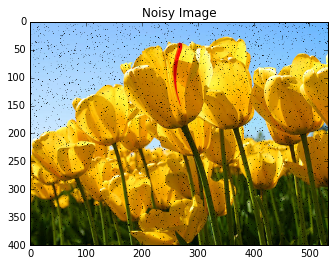

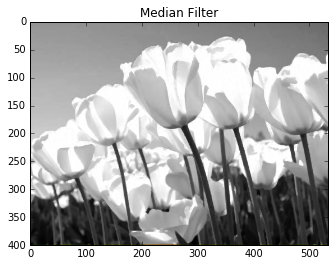

Temps de traitement : 1.3476393222808838


In [25]:
from scipy import misc

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from time import time




img_originale = mpimg.imread('assets/Tulips.jpg')

print ("Largeur : "+str(img_originale.shape[0]))

print ("Height : "+str(img_originale.shape[1]))
plt.imshow(img_originale) 
salt_value = 40

noise = np.random.randint(salt_value+1, size=(400, 533))



#---------- Add Noise ----------#

indexe = np.where(noise == 0)

A = indexe[0]
B = indexe[1]

img_originale[A,B,0] = 0.0
img_originale[A,B,1] = 0.0
img_originale[A,B,2] = 0.0

#---------- Plot & Save ----------#


my_dpi=100
   
plt.title("Noisy Image")
plt.savefig("assets/Tulips_noisy.jpg", dpi=my_dpi)
plt.show()

plt.imshow(img_originale)   
plt.title("Noisy Image")
plt.savefig("assets/Tulips_noisy.jpg",bbox_inches='tight')

#---------- Median Filter ----------#
       
start = time()
shape = img_originale.shape
M = img_originale
n_pixel = np.zeros((9))

for i in range(shape[0]-1):
    for j in range(shape[1]-1):
        if j > 0 and i > 0:
            n_pixel[0] = M[i-1,j-1,0]
            n_pixel[1] = M[i-1,j,0]
            n_pixel[2] = M[i-1,j+1,0]
            n_pixel[3] = M[i,j-1,0]
            n_pixel[4] = M[i,j,0]
            n_pixel[5] = M[i,j+1,0]
            n_pixel[6] = M[i+1,j-1,0]
            n_pixel[7] = M[i+1,j,0]
            n_pixel[8] = M[i+1,j+1,0]
            s = np.sort(n_pixel, axis=None)  
            M[i,j,0] = s[4]
            M[i,j,1] = s[4]
            M[i,j,2] = s[4]
end = time()



plt.imshow(M)   
plt.title("Median Filter")
plt.savefig("TulipsMedianFilterTulips.png",bbox_inches='tight')
plt.show()
print("Temps de traitement : "+str(end-start))